In [7]:
!pip install groq python-dotenv numpy tqdm datasets -q

In [ ]:
from groq import Groq
from dotenv import load_dotenv
from datasets import load_dataset

import os
from tqdm import tqdm
import re
import random
import pprint
from typing import List, Dict, Any
load_dotenv()
random.seed(0)

client = Groq()
gsm8k_dataset = load_dataset("gsm8k", "main")

gsm8k_train = gsm8k_dataset["train"]
gsm8k_test  = gsm8k_dataset["test"]

In [10]:
def generate_response_using_Llama(
        prompt: str,
        model: str = "llama-3.1-8b-instant"
    ):
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant that solves math problems."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            model=model,
            temperature=0, ### 수정해도 됩니다!
            stream=False
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"API call error: {str(e)}")
        return None

#### 응답 잘 나오는지 확인해보기

In [ ]:
response = generate_response_using_Llama(
    prompt="Hello world!",
)
print(response)

Hello. What math problem would you like help with today?


#### GSM8K 데이터셋 확인해보기

In [ ]:
print("[Question]")
for l in gsm8k_test['question'][0].split("."):
    print(l)
print("="*100)
print("[Answer]")
print(gsm8k_test['answer'][0])

[Question]
Janet’s ducks lay 16 eggs per day
 She eats three for breakfast every morning and bakes muffins for her friends every day with four
 She sells the remainder at the farmers' market daily for $2 per fresh duck egg
 How much in dollars does she make every day at the farmers' market?
[Answer]
Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18


#### Util 함수들
- extract_final_answer: LLM의 응답을 parse하여 최종 결과만 추출 (정답과 비교하기 위해)
- run_benchmark_test: 벤치마크 테스트
- save_final_result: 결과물 제출을 위한 함수

In [11]:
### 수정해도 됩니다!
def extract_final_answer(response: str):
    regex = r"(?:Answer:|Model response:)\s*\$?([0-9,]+)\b|([0-9,]+)\s*(meters|cups|miles|minutes)"
    matches = re.finditer(regex, response, re.MULTILINE)
    results = [match.group(1) if match.group(1) else match.group(2).replace(",", "") for match in matches]

    if len(results) == 0:
        additional_regex = r"\$?([0-9,]+)"
        additional_matches = re.finditer(additional_regex, response, re.MULTILINE)
        results.extend([match.group(1).replace(",", "") for match in additional_matches])

    return results[-1] if results else None

In [12]:
import re
from tqdm import tqdm

def run_benchmark_test(
        dataset,
        prompt: str,
        model: str = "llama-3.1-8b-instant",
        num_samples: int = 50,
        VERBOSE: bool = False
    ):
    correct = 0
    total   = 0
    results = []

    # Configuration for retry mechanism
    max_retries = 3

    for i in tqdm(range(min(num_samples, len(dataset)))):
        question = dataset[i]["question"]
        # Extract the correct numerical answer from the dataset
        correct_answer = float(re.findall(r'\d+(?:\.\d+)?', dataset[i]["answer"].split('####')[-1])[0])

        predicted_answer = None
        final_response = ""

        # --- RETRY LOOP START ---
        for attempt in range(max_retries):
            try:
                # Generate response
                response = generate_response_using_Llama(
                    prompt=prompt.format(question=question),
                    model=model
                )
                final_response = response # Keep track of the last response for logging

                if VERBOSE:
                    print(f"\n[Attempt {attempt+1}/{max_retries}]")
                    print("="*50)
                    print(response)
                    print("="*50)

                if response:
                    extracted_str = extract_final_answer(response)

                    # Check if extraction is valid and not empty
                    if isinstance(extracted_str, str) and extracted_str.strip():
                        # Try converting to float. If this fails, it goes to 'except'
                        predicted_answer = float(extracted_str.replace(",", ""))

                        # If successful, break the retry loop immediately
                        break
                    else:
                        # Force a retry if extraction returned empty/None
                        raise ValueError("Empty extraction or invalid format")

            except Exception as e:
                # If it is the last attempt, we stop trying; otherwise, continue to next attempt
                if attempt < max_retries - 1:
                    continue
                else:
                    pass
        # --- RETRY LOOP END ---

        # Calculate accuracy only if we successfully got a predicted_answer
        if predicted_answer is not None:
            diff = abs(predicted_answer - correct_answer)
            is_correct = diff < 1e-5
        else:
            is_correct = False

        if is_correct:
            correct += 1
        total += 1

        results.append({
            'question': question,
            'correct_answer': correct_answer,
            'predicted_answer': predicted_answer,
            'response': final_response,
            'correct': is_correct
        })

        if (i + 1) % 5 == 0:
            current_acc = correct/total if total > 0 else 0
            print(f"Progress: [{i+1}/{min(num_samples, len(dataset))}]")
            print(f"Current Acc.: [{current_acc:.2%}]")

    return results, correct/total if total > 0 else 0

In [13]:
def save_final_result(results: List[Dict[str, Any]], accuracy: float, filename: str) -> None:
    result_str = f"====== ACCURACY: {accuracy} ======\n\n"
    result_str += f"[Details]\n"

    for idx, result in enumerate(results):
        result_str += f"Question {idx+1}: {result['question']}\n"
        result_str += f"Correct Answer: {result['correct_answer']}\n"
        result_str += f"Predicted Answer: {result['predicted_answer']}\n"
        result_str += f"Correct: {result['correct']}\n\n"

    with open(filename, "w", encoding="utf-8") as f:
        f.write(result_str)

#### Direct prompting with few-shot example

In [ ]:
def construct_direct_prompt(num_examples: int = 3) -> str:
    train_dataset = gsm8k_train

    sampled_indices = random.sample(
        [i for i in range(len(train_dataset['question']))],
        num_examples
    )

    prompt = "Instruction:\nSolve the following mathematical question and generate ONLY the answer after a tag, 'Answer:' without any rationale.\n"

    for i in range(num_examples):
        cur_question = train_dataset['question'][i]
        cur_answer = train_dataset['answer'][i].split("####")[-1].strip()

        prompt += f"\n[Example {i+1}]\n"
        prompt += f"Question:\n{cur_question}\n"
        prompt += f"Answer:{cur_answer}\n"

    prompt += "\nQuestion:\n{question}\nAnswer:"

    return prompt

In [ ]:
### 어떤 방식으로 저장되는지 확인해보세요!
PROMPT = construct_direct_prompt(3)
VERBOSE = False

results, accuracy = run_benchmark_test(
    dataset=gsm8k_test,
    prompt=PROMPT,
    VERBOSE=VERBOSE,
    num_samples=10
)
save_final_result(results, accuracy, "example.txt")

 50%|█████     | 5/10 [00:15<00:18,  3.78s/it]

Progress: [5/10]
Current Acc.: [60.00%]


100%|██████████| 10/10 [00:32<00:00,  3.29s/it]

Progress: [10/10]
Current Acc.: [50.00%]


Testing with 0 shot(s)...


 10%|█         | 5/50 [00:10<01:36,  2.14s/it]

Progress: [5/50]
Current Acc.: [80.00%]


 20%|██        | 10/50 [00:20<01:25,  2.13s/it]

Progress: [10/50]
Current Acc.: [70.00%]


 30%|███       | 15/50 [00:30<01:14,  2.12s/it]

Progress: [15/50]
Current Acc.: [80.00%]


 40%|████      | 20/50 [00:41<01:07,  2.23s/it]

Progress: [20/50]
Current Acc.: [75.00%]


 50%|█████     | 25/50 [00:50<00:42,  1.69s/it]

Progress: [25/50]
Current Acc.: [76.00%]


 60%|██████    | 30/50 [01:02<00:43,  2.18s/it]

Progress: [30/50]
Current Acc.: [80.00%]


 70%|███████   | 35/50 [01:12<00:29,  1.99s/it]

Progress: [35/50]
Current Acc.: [82.86%]


 80%|████████  | 40/50 [01:22<00:21,  2.19s/it]

Progress: [40/50]
Current Acc.: [82.50%]


 90%|█████████ | 45/50 [01:33<00:11,  2.21s/it]

Progress: [45/50]
Current Acc.: [82.22%]


100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


Progress: [50/50]
Current Acc.: [84.00%]
-> Accuracy for 0-shot: 84.00%
Testing with 3 shot(s)...


 10%|█         | 5/50 [00:24<03:40,  4.89s/it]

Progress: [5/50]
Current Acc.: [60.00%]


 20%|██        | 10/50 [00:41<02:29,  3.74s/it]

Progress: [10/50]
Current Acc.: [50.00%]


 30%|███       | 15/50 [00:58<01:59,  3.42s/it]

Progress: [15/50]
Current Acc.: [60.00%]


 40%|████      | 20/50 [01:16<01:42,  3.42s/it]

Progress: [20/50]
Current Acc.: [70.00%]


 50%|█████     | 25/50 [01:32<01:21,  3.28s/it]

Progress: [25/50]
Current Acc.: [68.00%]


 60%|██████    | 30/50 [01:48<01:05,  3.30s/it]

Progress: [30/50]
Current Acc.: [70.00%]


 70%|███████   | 35/50 [02:05<00:48,  3.27s/it]

Progress: [35/50]
Current Acc.: [74.29%]


 80%|████████  | 40/50 [02:29<00:46,  4.66s/it]

Progress: [40/50]
Current Acc.: [75.00%]


 90%|█████████ | 45/50 [02:49<00:20,  4.06s/it]

Progress: [45/50]
Current Acc.: [73.33%]


100%|██████████| 50/50 [03:07<00:00,  3.75s/it]


Progress: [50/50]
Current Acc.: [74.00%]
-> Accuracy for 3-shot: 74.00%
Testing with 5 shot(s)...


 10%|█         | 5/50 [00:29<05:20,  7.13s/it]

Progress: [5/50]
Current Acc.: [60.00%]


 20%|██        | 10/50 [00:52<03:18,  4.97s/it]

Progress: [10/50]
Current Acc.: [60.00%]


 30%|███       | 15/50 [01:25<04:02,  6.92s/it]

Progress: [15/50]
Current Acc.: [60.00%]


 40%|████      | 20/50 [01:48<02:25,  4.84s/it]

Progress: [20/50]
Current Acc.: [65.00%]


 50%|█████     | 25/50 [02:16<02:00,  4.82s/it]

Progress: [25/50]
Current Acc.: [68.00%]


 60%|██████    | 30/50 [02:44<01:56,  5.81s/it]

Progress: [30/50]
Current Acc.: [70.00%]


 70%|███████   | 35/50 [03:06<01:07,  4.52s/it]

Progress: [35/50]
Current Acc.: [74.29%]


 80%|████████  | 40/50 [03:28<00:47,  4.70s/it]

Progress: [40/50]
Current Acc.: [77.50%]


 90%|█████████ | 45/50 [03:53<00:24,  4.97s/it]

Progress: [45/50]
Current Acc.: [73.33%]


100%|██████████| 50/50 [04:16<00:00,  5.14s/it]

Progress: [50/50]
Current Acc.: [74.00%]
-> Accuracy for 5-shot: 74.00%

=== Accuracy Summary ===
Shots | Accuracy
------+----------
    0 | 0.8400
    3 | 0.7400
    5 | 0.7400

[Info] Accuracy trend plot saved as 'accuracy_trend.png'


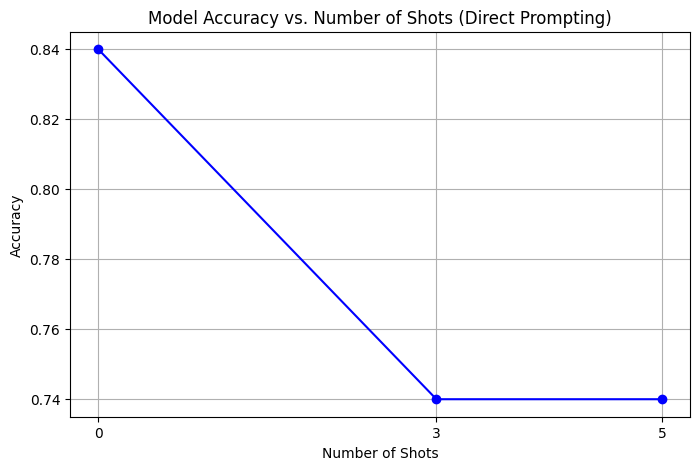

In [ ]:
# TODO: 0 shot, 3 shot, 5 shot direct prompting을 통해 벤치마크 테스트를 한 후, 각각 direct_prompting_{shot: int}.txt로 저장해주세요!
# 예시: shot이 5인 경우 direct_prompting_5.txt
# 항상 num_samples=50 입니다!
import matplotlib.pyplot as plt

accuracy_history_direct = {}

def run_model_with_shots(shot: int):

    PROMPT = construct_direct_prompt(shot)
    VERBOSE = False

    results, accuracy = run_benchmark_test(
        dataset=gsm8k_test,
        prompt=PROMPT,
        VERBOSE=VERBOSE,
        num_samples=50
    )

    save_final_result(results, accuracy, f"direct_prompting_{shot}.txt")

    return accuracy

# Main Loop
shot_counts = [0, 3, 5]

for shot in shot_counts:
    print(f'Testing with {shot} shot(s)...')

    acc = run_model_with_shots(shot)
    accuracy_history_direct[shot] = acc
    print(f"-> Accuracy for {shot}-shot: {acc:.2%}")


print("\n=== Accuracy Summary ===")
print("Shots | Accuracy")
print("------+----------")
for shot, acc in accuracy_history_direct.items():
    print(f"{shot:5d} | {acc:.4f}")

try:
    shots = list(accuracy_history_direct.keys())
    accs = list(accuracy_history_direct.values())

    plt.figure(figsize=(8, 5))
    plt.plot(shots, accs, marker='o', linestyle='-', color='b')
    plt.title(f'Model Accuracy vs. Number of Shots (Direct Prompting)')
    plt.xlabel('Number of Shots')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(shots)
    plt.savefig('accuracy_trend_direct.png')
    print("\n[Info] Accuracy trend plot saved as 'accuracy_trend.png'")
    plt.show()
except Exception as e:
    print(f"\n[Note] Could not generate plot: {e}")

### Chain-of-Thought prompting with few-shot example
```text
[Question]
Janet’s ducks lay 16 eggs per day
 She eats three for breakfast every morning and bakes muffins for her friends every day with four
 She sells the remainder at the farmers' market daily for $2 per fresh duck egg
 How much in dollars does she make every day at the farmers' market?
====================================================================================================
[Answer]
Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18
```

[Answer] 아래의 정답을 도출하는 과정을 예시로 달아주면 CoT의 few shot이 되겠죠?

In [ ]:
def construct_CoT_prompt(num_examples: int = 3) -> str:
    train_dataset = gsm8k_train

    sampled_indices = random.sample(
        [i for i in range(len(train_dataset['question']))],
        num_examples
    )
    prompt = ("Solve the following math problems. "
        "For each problem, think step by step to arrive at the solution. "
        "At the end of your solution, Solve the following mathematical question and generate ONLY the answer after a tag, 'Answer:'\n\n")

    for i in range(num_examples):
        #TODO: CoT example을 만들어주세요!
        q = train_dataset['question'][sampled_indices[i]]
        a = train_dataset['answer'][sampled_indices[i]]
        prompt += f"Question:\n{q}\n"
        prompt += f"Answer:\n{a}\n\n"

    prompt += "\nQuestion:\n{question}\nAnswer:"

    return prompt


Testing with 0 shot(s)...


 10%|█         | 5/50 [00:02<00:17,  2.57it/s]

Progress: [5/50]
Current Acc.: [60.00%]


 20%|██        | 10/50 [00:03<00:14,  2.77it/s]

Progress: [10/50]
Current Acc.: [50.00%]


 30%|███       | 15/50 [00:05<00:12,  2.74it/s]

Progress: [15/50]
Current Acc.: [53.33%]


 40%|████      | 20/50 [00:12<00:48,  1.61s/it]

Progress: [20/50]
Current Acc.: [55.00%]


 50%|█████     | 25/50 [00:24<00:56,  2.25s/it]

Progress: [25/50]
Current Acc.: [60.00%]


 60%|██████    | 30/50 [00:37<00:53,  2.68s/it]

Progress: [30/50]
Current Acc.: [63.33%]


 70%|███████   | 35/50 [00:49<00:36,  2.43s/it]

Progress: [35/50]
Current Acc.: [65.71%]


 80%|████████  | 40/50 [01:03<00:28,  2.82s/it]

Progress: [40/50]
Current Acc.: [67.50%]


 90%|█████████ | 45/50 [01:18<00:15,  3.09s/it]

Progress: [45/50]
Current Acc.: [68.89%]


100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


Progress: [50/50]
Current Acc.: [70.00%]
-> Accuracy for 0-shot: 70.00%
Testing with 3 shot(s)...


 10%|█         | 5/50 [00:44<06:43,  8.96s/it]

Progress: [5/50]
Current Acc.: [40.00%]


 20%|██        | 10/50 [01:27<05:24,  8.11s/it]

Progress: [10/50]
Current Acc.: [40.00%]


 30%|███       | 15/50 [02:13<05:14,  8.99s/it]

Progress: [15/50]
Current Acc.: [53.33%]


 40%|████      | 20/50 [03:00<04:37,  9.27s/it]

Progress: [20/50]
Current Acc.: [50.00%]


 50%|█████     | 25/50 [03:36<02:44,  6.60s/it]

Progress: [25/50]
Current Acc.: [56.00%]


 60%|██████    | 30/50 [04:19<02:49,  8.48s/it]

Progress: [30/50]
Current Acc.: [63.33%]


 70%|███████   | 35/50 [05:03<02:09,  8.62s/it]

Progress: [35/50]
Current Acc.: [68.57%]


 80%|████████  | 40/50 [05:47<01:30,  9.01s/it]

Progress: [40/50]
Current Acc.: [70.00%]


 90%|█████████ | 45/50 [06:25<00:39,  7.89s/it]

Progress: [45/50]
Current Acc.: [73.33%]


100%|██████████| 50/50 [07:02<00:00,  8.45s/it]


Progress: [50/50]
Current Acc.: [74.00%]
-> Accuracy for 3-shot: 74.00%
Testing with 5 shot(s)...


 10%|█         | 5/50 [01:12<10:53, 14.53s/it]

Progress: [5/50]
Current Acc.: [80.00%]


 20%|██        | 10/50 [02:25<09:45, 14.64s/it]

Progress: [10/50]
Current Acc.: [60.00%]


 30%|███       | 15/50 [03:38<08:30, 14.58s/it]

Progress: [15/50]
Current Acc.: [66.67%]


 40%|████      | 20/50 [04:51<07:18, 14.63s/it]

Progress: [20/50]
Current Acc.: [75.00%]


 50%|█████     | 25/50 [06:04<06:04, 14.56s/it]

Progress: [25/50]
Current Acc.: [80.00%]


 60%|██████    | 30/50 [07:17<04:50, 14.54s/it]

Progress: [30/50]
Current Acc.: [83.33%]


 70%|███████   | 35/50 [08:30<03:41, 14.75s/it]

Progress: [35/50]
Current Acc.: [85.71%]


 80%|████████  | 40/50 [09:34<02:07, 12.72s/it]

Progress: [40/50]
Current Acc.: [82.50%]


 90%|█████████ | 45/50 [10:45<01:10, 14.12s/it]

Progress: [45/50]
Current Acc.: [82.22%]


100%|██████████| 50/50 [11:57<00:00, 14.36s/it]

Progress: [50/50]
Current Acc.: [84.00%]
-> Accuracy for 5-shot: 84.00%

=== Accuracy Summary ===
Shots | Accuracy
------+----------
    0 | 0.7000
    3 | 0.7400
    5 | 0.8400

[Info] Accuracy trend plot saved as 'accuracy_trend.png'


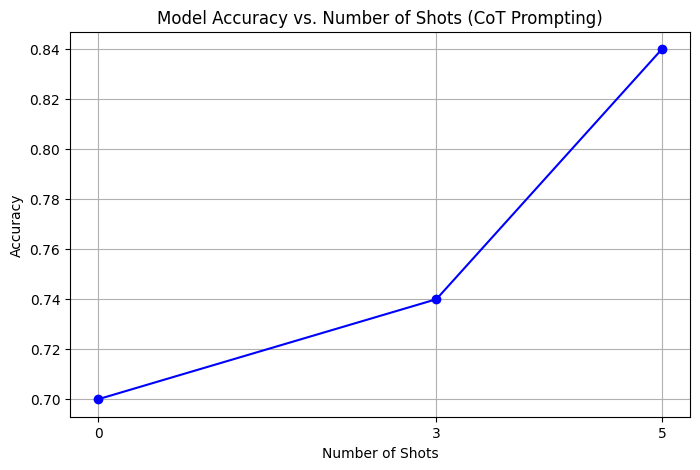

In [15]:
# TODO: 0 shot, 3 shot, 5 shot CoT prompting을 통해 벤치마크 테스트를 한 후, 각각 CoT_prompting_{shot: int}.txt로 저장해주세요!
# 예시: shot이 5인 경우 CoT_prompting_5.txt
# 항상 num_samples=50 입니다!
import matplotlib.pyplot as plt

accuracy_history_CoT = {}

def run_model_with_shots(shot: int):

    PROMPT = construct_CoT_prompt(shot)
    VERBOSE = False

    results, accuracy = run_benchmark_test(
        dataset=gsm8k_test,
        prompt=PROMPT,
        VERBOSE=VERBOSE,
        num_samples=50
    )

    save_final_result(results, accuracy, f"CoT_prompting_{shot}.txt")

    return accuracy

# Main Loop
shot_counts = [0, 3, 5]

for shot in shot_counts:
    print(f'Testing with {shot} shot(s)...')

    acc = run_model_with_shots(shot)
    accuracy_history_CoT[shot] = acc
    print(f"-> Accuracy for {shot}-shot: {acc:.2%}")


print("\n=== Accuracy Summary ===")
print("Shots | Accuracy")
print("------+----------")
for shot, acc in accuracy_history_CoT.items():
    print(f"{shot:5d} | {acc:.4f}")

try:
    shots = list(accuracy_history_CoT.keys())
    accs = list(accuracy_history_CoT.values())

    plt.figure(figsize=(8, 5))
    plt.plot(shots, accs, marker='o', linestyle='-', color='b')
    plt.title(f'Model Accuracy vs. Number of Shots (CoT Prompting)')
    plt.xlabel('Number of Shots')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(shots)
    plt.savefig('accuracy_trend_CoT.png')
    print("\n[Info] Accuracy trend plot saved as 'accuracy_trend.png'")
    plt.show()
except Exception as e:
    print(f"\n[Note] Could not generate plot: {e}")

### Construct your prompt!!

목표: 본인만의 프롬프트를 통해 정답률을 더 끌어올려보기!
- gsm8k의 train 데이터셋에서 예시를 가져온 다음 (자유롭게!)
- 그 예시들에 대한 풀이 과정을 만들어주세요!
- 모든 것들이 자유입니다! Direct Prompting, CoT Prompting을 한 결과보다 정답률만 높으면 돼요.

In [ ]:
def construct_my_prompt(num_examples: int = 3) -> str:
    train_dataset = gsm8k_train

    sampled_indices = random.sample(
        [i for i in range(len(train_dataset['question']))],
        num_examples
    )
    prompt = ("Solve the following math problems. "
        "For each problem, think step by step to arrive at the solution. "
        "after you got your answer, verify your answer for correctness. "
        "At the end of your solution, Solve the following mathematical question and generate ONLY the answer after a tag, 'Answer:'\n\n")

    for i in range(num_examples):
        #TODO: CoT example을 만들어주세요!
        q = train_dataset['question'][sampled_indices[i]]
        a = train_dataset['answer'][sampled_indices[i]]
        prompt += f"Question:\n{q}\n"
        prompt += f"Answer:\n{a}\n\n"

    prompt += "\nQuestion:\n{question}\nAnswer:"

    return prompt


Testing with 0 shot(s)...


 10%|█         | 5/50 [00:02<00:20,  2.14it/s]

Progress: [5/50]
Current Acc.: [80.00%]


 20%|██        | 10/50 [00:06<00:35,  1.14it/s]

Progress: [10/50]
Current Acc.: [70.00%]


 30%|███       | 15/50 [00:13<00:58,  1.68s/it]

Progress: [15/50]
Current Acc.: [73.33%]


 40%|████      | 20/50 [00:25<01:10,  2.35s/it]

Progress: [20/50]
Current Acc.: [75.00%]


 50%|█████     | 25/50 [00:38<01:00,  2.43s/it]

Progress: [25/50]
Current Acc.: [76.00%]


 60%|██████    | 30/50 [00:50<00:48,  2.44s/it]

Progress: [30/50]
Current Acc.: [80.00%]


 70%|███████   | 35/50 [01:02<00:36,  2.47s/it]

Progress: [35/50]
Current Acc.: [82.86%]


 80%|████████  | 40/50 [01:15<00:25,  2.55s/it]

Progress: [40/50]
Current Acc.: [85.00%]


 90%|█████████ | 45/50 [01:29<00:13,  2.62s/it]

Progress: [45/50]
Current Acc.: [86.67%]


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


Progress: [50/50]
Current Acc.: [88.00%]
-> Accuracy for 0-shot: 88.00%
Testing with 3 shot(s)...


 10%|█         | 5/50 [00:40<06:06,  8.14s/it]

Progress: [5/50]
Current Acc.: [100.00%]


 20%|██        | 10/50 [01:19<05:04,  7.62s/it]

Progress: [10/50]
Current Acc.: [70.00%]


 30%|███       | 15/50 [01:57<04:36,  7.89s/it]

Progress: [15/50]
Current Acc.: [73.33%]


 40%|████      | 20/50 [02:34<03:57,  7.92s/it]

Progress: [20/50]
Current Acc.: [75.00%]


 50%|█████     | 25/50 [03:22<03:29,  8.40s/it]

Progress: [25/50]
Current Acc.: [76.00%]


 60%|██████    | 30/50 [03:56<02:24,  7.21s/it]

Progress: [30/50]
Current Acc.: [76.67%]


 70%|███████   | 35/50 [04:37<02:00,  8.01s/it]

Progress: [35/50]
Current Acc.: [80.00%]


 80%|████████  | 40/50 [05:09<01:13,  7.32s/it]

Progress: [40/50]
Current Acc.: [77.50%]


 90%|█████████ | 45/50 [05:49<00:36,  7.40s/it]

Progress: [45/50]
Current Acc.: [77.78%]


100%|██████████| 50/50 [06:30<00:00,  7.82s/it]


Progress: [50/50]
Current Acc.: [78.00%]
-> Accuracy for 3-shot: 78.00%
Testing with 5 shot(s)...


 10%|█         | 5/50 [00:57<08:38, 11.53s/it]

Progress: [5/50]
Current Acc.: [80.00%]


 20%|██        | 10/50 [01:55<07:40, 11.52s/it]

Progress: [10/50]
Current Acc.: [70.00%]


 30%|███       | 15/50 [03:02<07:31, 12.91s/it]

Progress: [15/50]
Current Acc.: [73.33%]


 40%|████      | 20/50 [03:55<05:38, 11.29s/it]

Progress: [20/50]
Current Acc.: [80.00%]


 50%|█████     | 25/50 [05:28<05:12, 12.52s/it]

Progress: [25/50]
Current Acc.: [76.00%]


 60%|██████    | 30/50 [06:16<03:08,  9.44s/it]

Progress: [30/50]
Current Acc.: [80.00%]


 70%|███████   | 35/50 [07:14<02:48, 11.23s/it]

Progress: [35/50]
Current Acc.: [82.86%]


 80%|████████  | 40/50 [08:12<01:55, 11.52s/it]

Progress: [40/50]
Current Acc.: [82.50%]


 90%|█████████ | 45/50 [09:11<00:58, 11.61s/it]

Progress: [45/50]
Current Acc.: [82.22%]


100%|██████████| 50/50 [10:08<00:00, 12.17s/it]

Progress: [50/50]
Current Acc.: [84.00%]
-> Accuracy for 5-shot: 84.00%

=== Accuracy Summary ===
Shots | Accuracy
------+----------
    0 | 0.8800
    3 | 0.7800
    5 | 0.8400

[Info] Accuracy trend plot saved as 'accuracy_trend_my.png'


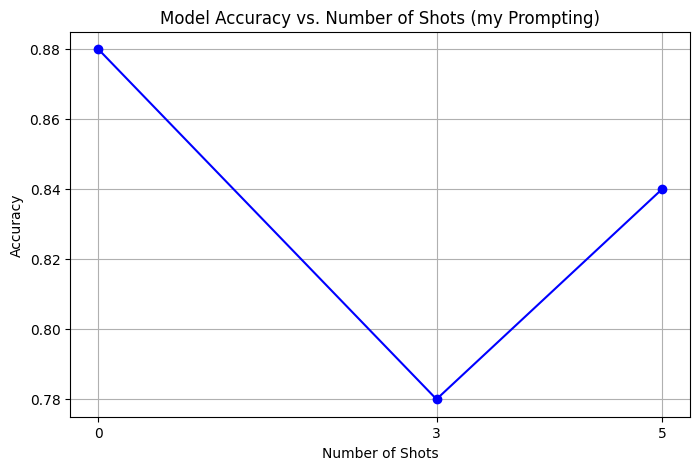

In [26]:
# TODO: 만든 0 shot, 3 shot, 5 shot example과 프롬프트를 통해 벤치마크 테스트를 한 후, 각각 My_prompting_{shot: int}.txt로 저장해주세요!
# 예시: shot이 5인 경우 My_prompting_5.txt
# 항상 num_samples=50 입니다!

accuracy_history_my = {}

def run_model_with_shots(shot: int):

    PROMPT = construct_my_prompt(shot)
    VERBOSE = False
    max_retries = 3

    results, accuracy = run_benchmark_test(
        dataset=gsm8k_test,
        prompt=PROMPT,
        VERBOSE=VERBOSE,
        num_samples=50
    )

    save_final_result(results, accuracy, f"My_prompting_{shot}.txt")

    return accuracy


# Main Loop
shot_counts = [0, 3, 5]

for shot in shot_counts:
    print(f'Testing with {shot} shot(s)...')

    acc = run_model_with_shots(shot)
    accuracy_history_my[shot] = acc
    print(f"-> Accuracy for {shot}-shot: {acc:.2%}")


print("\n=== Accuracy Summary ===")
print("Shots | Accuracy")
print("------+----------")
for shot, acc in accuracy_history_my.items():
    print(f"{shot:5d} | {acc:.4f}")

try:
    shots = list(accuracy_history_my.keys())
    accs = list(accuracy_history_my.values())

    plt.figure(figsize=(8, 5))
    plt.plot(shots, accs, marker='o', linestyle='-', color='b')
    plt.title(f'Model Accuracy vs. Number of Shots (my Prompting)')
    plt.xlabel('Number of Shots')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(shots)
    plt.savefig('accuracy_trend_my.png')
    print("\n[Info] Accuracy trend plot saved as 'accuracy_trend_my.png'")
    plt.show()
except Exception as e:
    print(f"\n[Note] Could not generate plot: {e}")


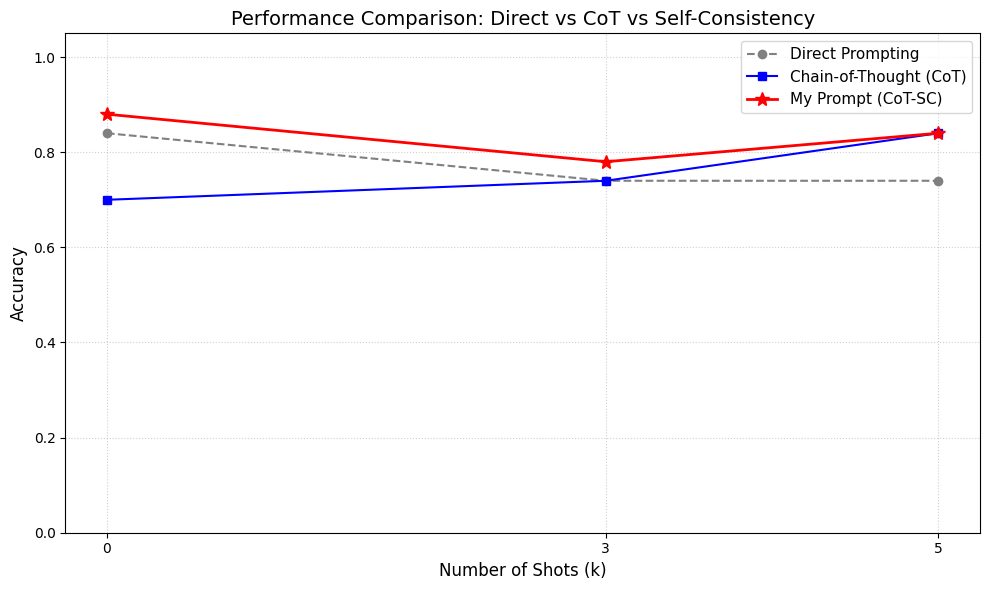

In [27]:
def plot_comparison(history_direct, history_cot, history_my):
    plt.figure(figsize=(10, 6))

    def get_sorted_xy(data_dict):
        sorted_items = sorted(data_dict.items())
        x = [item[0] for item in sorted_items]
        y = [item[1] for item in sorted_items]
        return x, y

    x1, y1 = get_sorted_xy(history_direct)
    plt.plot(x1, y1, marker='o', linestyle='--', color='gray', label='Direct Prompting')

    x2, y2 = get_sorted_xy(history_cot)
    plt.plot(x2, y2, marker='s', linestyle='-', color='blue', label='Chain-of-Thought (CoT)')

    x3, y3 = get_sorted_xy(history_my)
    plt.plot(x3, y3, marker='*', linestyle='-', color='red', linewidth=2, markersize=10, label='My Prompt (CoT-SC)')

    plt.title('Performance Comparison: Direct vs CoT vs Self-Consistency', fontsize=14)
    plt.xlabel('Number of Shots (k)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.xticks(sorted(list(set(x1 + x2 + x3))))
    plt.ylim(0, 1.05)

    plt.legend(fontsize=11)

    plt.tight_layout()
    plt.savefig('comparison_result.png', dpi=300)
    plt.show()


plot_comparison(accuracy_history_direct, accuracy_history_CoT, accuracy_history_my)

### 보고서 작성하기
#### 아래의 내용이 포함되면 됩니다!

1. Direct Prompting, CoT Prompting, My Prompting을 0 shot, 3 shot, 5 shot 정답률을 표로 보여주세요!
2. CoT Prompting이 Direct Prompting에 비해 왜 좋을 수 있는지에 대해서 서술해주세요!
3. 본인이 작성한 프롬프트 기법이 CoT에 비해서 왜 더 좋을 수 있는지에 대해서 설명해주세요!
4. 최종적으로, `PROMPTING.md`에 보고서를 작성해주세요!